In [1]:
from ultralytics import YOLO
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageFile
import ultralytics.engine.results as results
import PIL
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from importlib import reload

def plot_gt(path,ax):
    data=np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt")).T
    # print(data)
    cls = data[0]
    bboxes = data[1:-1].T
    z = data[-1]
    # print(bboxes)
    img = PIL.Image.open(path)
    ax.imshow(np.array(img))
    ax.axis("off")
    for bbox,z_value in zip(bboxes,z):
        x,y,w,h = bbox*512
        rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="blue", facecolor='none')
        ax.text(*rect.get_xy(),f"z={z_value:.3f}")
        ax.add_patch(rect)
    return bboxes,z

In [2]:
# reload(results)
model = YOLO("runs/zaxis/train49/weights/last.pt")
# print(model.model.model)
print("loaded")
test_images = os.listdir("data_gen/Dataset/images/test")
random_image = lambda: "data_gen/Dataset/images/test/"+test_images[np.random.randint(0,len(test_images))]



loaded


In [3]:
# print(model.model)


image 1/1 /home/jupyter-till/git/ultralytics/data_gen/Dataset/images/test/image_00335.tif: 512x512 5.5ms
Speed: 9.6ms preprocess, 5.5ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)


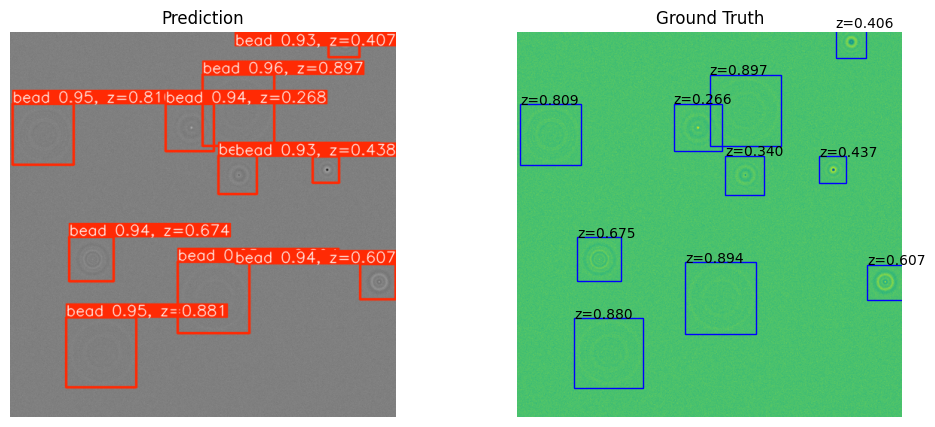

In [6]:

plt.figure(figsize=(12,5))
image = random_image()
results = model.predict(image)
res = results[0].plot()
plt.subplot(1,2,1)
plt.title("Prediction")
plt.imshow(res)
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Ground Truth")

bboxes,z_values = plot_gt(image,plt.gca())
plt.show()

In [7]:
res = results[0].zaxis.data.cpu().numpy()

302.89304 104.27702 95.18713 95.3064
120.88045 426.19962 92.40909 92.44806
269.8247 353.07916 94.55284 94.30286
43.782127 136.06995 80.65932 80.8944
238.75273 126.95154 63.507538 63.483215
302.12994 189.99844 51.647827 51.648926
108.072685 302.0525 58.78389 58.62378
488.05093 332.00153 47.498596 47.68213
442.9765 13.026768 40.60193 40.60193
418.97974 183.10263 35.562744 35.624084
[[     43.899      135.99      80.735      80.735]
 [     121.17      426.32       92.39       92.39]
 [     443.41      13.456      40.625      40.625]
 [     269.94      353.14        94.7        94.7]
 [     108.47       301.7       58.58       58.58]
 [     488.32      332.43       47.45       47.45]
 [     302.71      103.96       95.12       95.12]
 [     302.01      190.06       51.44       51.44]
 [     239.44       126.5       63.62       63.62]
 [     418.51      182.79       35.48       35.48]] [    0.80919     0.88003     0.40587     0.89407     0.67454     0.60689     0.89662     0.34014     0.266

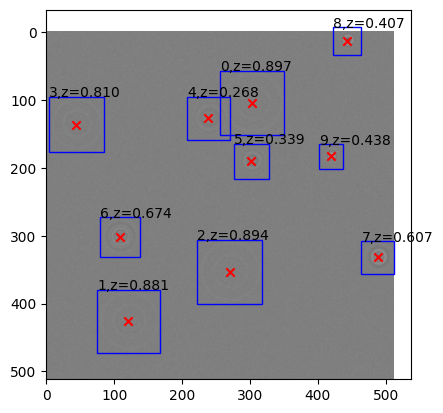

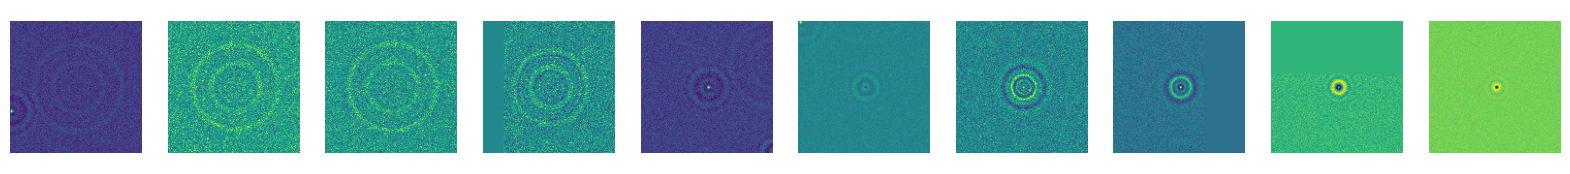

In [8]:
plt.figure()
plt.imshow(results[0].orig_img)
plt.figure(figsize=(20,2))
padding=128
size=128
padded_image = np.pad(results[0].orig_img[...,0],padding,mode="constant",constant_values=127)

plt.axis("off")
captures = np.empty((len(res),size,size))
for i,box in enumerate(res):
    # print(box)
    x1,y1,x2,y2,_,_,z = box
    w,h = x2-x1,y2-y1
    if(x1 == 0):
        x1-=h-w
        w = h
    if(y1 == 0):
        y1-=w-h
        h = w
    if(x2 == 511):
        x2+=h-w
        w = h
    if(y2 == 511):
        y2+=w-h
        h = w
    x,y = 0.5*(x1+x2),0.5*(y1+y2)
    print(x,y,w,h)
    plt.figure(1)
    rect = Rectangle((x1,y1),w,h, linewidth=1, edgecolor="blue", facecolor='none')
    plt.scatter(x,y,c="r",marker="x")
    plt.text(*rect.get_xy(),f"{i},z={z:.3f}")
    plt.gca().add_patch(rect)
    plt.figure(2)
    plt.subplot(1,len(res),i+1)
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    captures[i] = padded_image[y+padding-size//2:y+padding+size//2,x+padding-size//2:x+padding+size//2]
    plt.imshow(captures[i])
    plt.axis("off")
print(bboxes*512,z_values)
captures/=127
captures-=1

In [9]:
downsampled_reference = (np.load("data_gen/ripples_downsampled.npy")/10000)-2


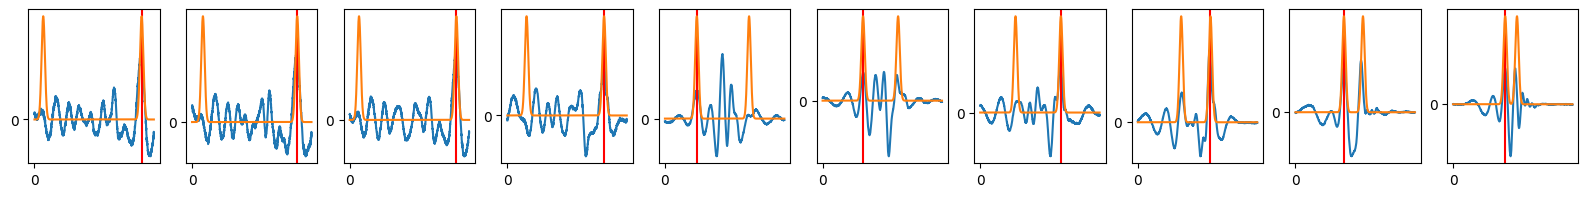

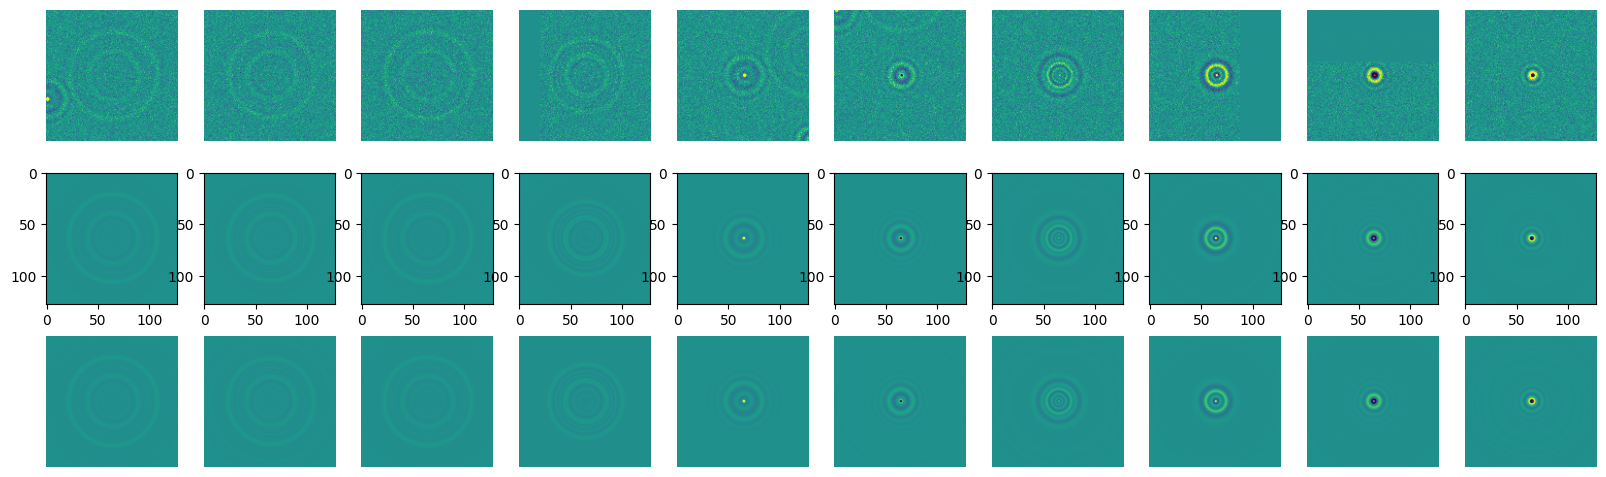

In [10]:
plt.figure(figsize=(20,2))
plt.figure(figsize=(20,6))
def bells(x,w,*args):
    f = np.sum([np.exp(-(w*(x-mu)**2)) for mu in args],axis=0)
    return f/np.max(f)
x = np.arange(len(downsampled_reference))
for i,capture in enumerate(captures):
    plt.figure(1)
    correlation = np.pow((downsampled_reference*capture).sum(axis=(1,2)),1)
    plt.subplot(1,len(captures),i+1)
    plt.plot(correlation)

    x1,y1,x2,y2,_,_,pred_z = res[i]
    w,h = x2-x1,y2-y1
    v = (max(w,h)*(2)-55)
    z  = (-v/0.21)+761,(v/0.21)+761
    plt.axvline(pred_z*len(downsampled_reference), c="red")
    plt.plot(bells(x,1e-3,*z)*(np.max(correlation)-np.min(correlation)))
    plt.xticks([0])
    plt.yticks([0])
    # plt.ylim(0,0.5)c
    # plt.tight_layout()

    plt.figure(2)
    plt.subplot(3,len(captures),i+1)
    plt.imshow(capture,vmin=-0.15,vmax=0.15)
    plt.axis("off")
    # plt.tight_layout()
    plt.subplot(3,len(captures),i+1+len(captures))
    plt.imshow(downsampled_reference[np.argmax(correlation*bells(x,1e-3,*z))],vmin=-0.1,vmax=0.1)
    plt.subplot(3,len(captures),i+1+2*len(captures))
    plt.imshow(downsampled_reference[np.round(pred_z*len(downsampled_reference)).astype(int)],vmin=-0.1,vmax=0.1)
    plt.axis("off")

    # plt.colorbar()

